In [27]:
import pandas as pd
import networkx as nx

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth

from itertools import chain, combinations
from functools import cmp_to_key

import matplotlib.pyplot as plt

# Задание 1

In [2]:
input_data = [
    list("ABCD"),
    list("ACDF"),
    list("ACDEG"),
    list("ABDF"),
    list("BCG"),
    list("DFG"),
    list("ABG"),
    list("CDFG")
]

te = TransactionEncoder()
trasaction_data = te.fit_transform(input_data)
data_frame = pd.DataFrame(trasaction_data, columns=te.columns_)
data_frame

,A,B,C,D,E,F,G
0,True,True,True,True,False,False,False
1,True,False,True,True,False,True,False
2,True,False,True,True,True,False,True
3,True,True,False,True,False,True,False
4,False,True,True,False,False,False,True
5,False,False,False,True,False,True,True
6,True,True,False,False,False,False,True
7,False,False,True,True,False,True,True


## APRIORI

In [36]:
def cmp(a, b):
    if ("".join(a) > "".join(b)): return 1
    if ("".join(a) < "".join(b)): return -1
    return 0

[frozenset({'A', 'B', 'C'}),
 frozenset({'A', 'B', 'D'}),
 frozenset({'B', 'C', 'D'})]

G: 0.625
D: 0.75
B: 0.5
F: 0.5
A: 0.625
C: 0.625
A D: 0.5
C D: 0.5
D G: 0.375
A C: 0.375
A B: 0.375
D F: 0.5
C G: 0.375
A C D: 0.375


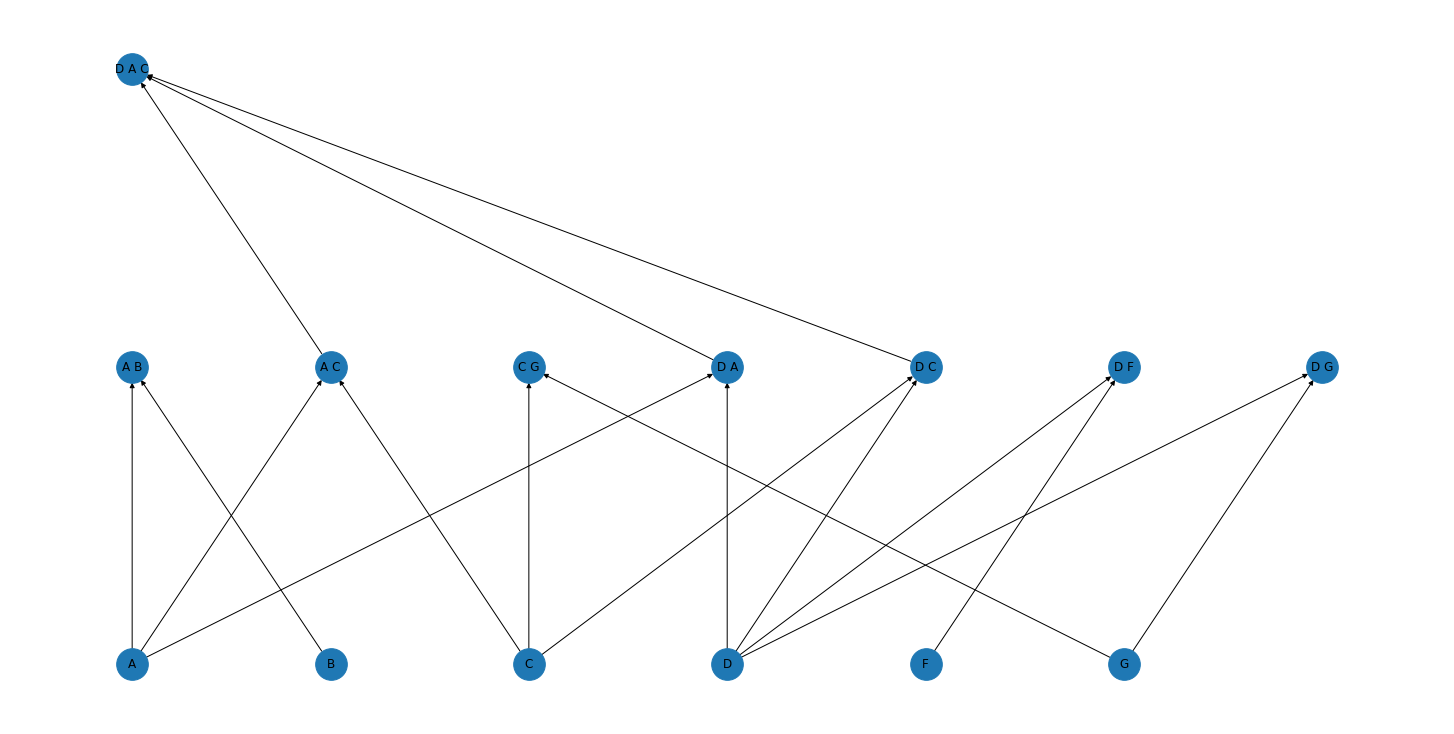

In [43]:
class impl_apriori:
    layers = []

    def __new__(_, data, min_support):
        apriori_gen.reset_graph()
        impl_apriori.layers = []
        L: list[dict[frozenset, int]] = []
        
        L_1 = list(map(
            lambda item: frozenset([item]),
            set(chain.from_iterable(data))
        ))
        impl_apriori.layers.append(L_1)

        support = {c: 0 for c in L_1}
        for t in data:
            for c in L_1:
                if c.issubset(t):
                    support[c] += 1

        L.append({key: value for key, value in support.items() if value/len(data) >= min_support})

        k = 0
        while L[k]:
            candidates = apriori_gen(L[k].keys())
            impl_apriori.layers.append(candidates)
            support = {c: 0 for c in candidates}
            for t in data:
                for c in candidates:
                    if c.issubset(t):
                        support[c] += 1
            L.append({key: value for key, value in support.items() if value/len(data) >= min_support})
            k += 1

        dall = {}
        for d in L:
            dall.update(d)
        return dict(map(lambda kv: (kv[0], kv[1]/len(data)), dall.items()))

class apriori_gen:
    digraph = nx.DiGraph()

    @staticmethod
    def reset_graph():
        apriori_gen.digraph = nx.DiGraph()

    @staticmethod
    def draw_graph():
        pass

    def __new__(_, itemsets):
        new_itemsets = list(set(map(
            lambda comb: frozenset(frozenset.union(*comb)),
            combinations(itemsets, 2)
        )))

        for new_iset in new_itemsets:
            for iset in itemsets:
                if iset.issubset(new_iset):
                    apriori_gen.digraph.add_edge(iset, new_iset)

        return new_itemsets


supports = impl_apriori(input_data, 3/8)
nodes_to_remove = list(apriori_gen.digraph.nodes())
for iset in supports.keys():
    if iset in nodes_to_remove:
        nodes_to_remove.remove(iset)

for node in nodes_to_remove:
    if node in apriori_gen.digraph.nodes():
        apriori_gen.digraph.remove_node(node)

pos = {}
for index, layer in enumerate(impl_apriori.layers):
    x = 0
    for node in sorted(apriori_gen.digraph.nodes(), key=cmp_to_key(cmp)):
        if node in layer:
            y = index
            pos[node] = (x, y)
            x+=1

for key, value in supports.items():
    print(f"{' '.join(sorted(list(key)))}: {value}")

plt.figure(figsize=(20, 10))
nx.draw(apriori_gen.digraph, pos,
    labels={node: ' '.join(node) for node in apriori_gen.digraph.nodes()},
    node_size=1000,
)
plt.show()




In [4]:
apriori_data = apriori(data_frame, min_support=3/8, use_colnames=True).sort_values("support", ascending=False)
apriori_data

,support,itemsets
3,0.750,(D)
0,0.625,(A)
2,0.625,(C)
5,0.625,(G)
1,0.500,(B)
4,0.500,(F)
8,0.500,"(D, A)"
9,0.500,"(D, C)"
11,0.500,"(D, F)"
6,0.375,"(A, B)"


## FP GROWTH

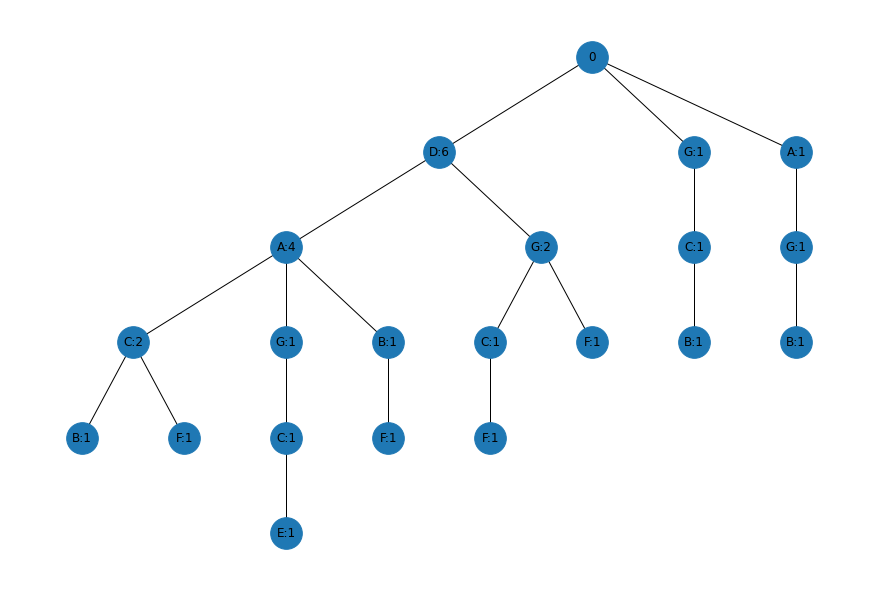

In [50]:
tree = nx.Graph()
tree.add_edges_from([
    ("NULL", "1"), ("NULL", "2"), ("NULL", "3"),
    ("1" , "4"), ("1" , "5"),
    
    ("2" , "6"), ("3" , "7"),

    ("4" , "8"), ("4" , "9"), ("4" , "10"),
    ("5" , "11"), ("5" , "12"),
    
    ("6" , "13"), ("7" , "14"),

    ("8" , "15"), ("8" , "16"),
    
    ("9" , "17"), ("10", "18"), ("11", "19"), ("17", "20"),
])
tree_pos = {
    "NULL": (6, 6),

    "1":  (4.5, 5), "4":  (3, 4), "8":  (1.5, 3),
    "9":  (3, 3), "10": (4, 3), "15": (1, 2),
    "16": (2, 2), "17": (3, 2), "18": (4, 2),
    "20": (3, 1),

    "5": (5.5, 4), "11": (5, 3), "12": (6, 3),
    "19": (5, 2),

    "2": (7, 5), "6": (7, 4), "13": (7, 3),
    "3": (8, 5), "7": (8, 4), "14": (8, 3)
}

plt.figure(figsize=(12, 8))
nx.draw(tree, tree_pos,
    labels={
        "NULL": "0", "1": "D:6", "2": "G:1", "3": "A:1",
        "4": "A:4", "5": "G:2", "6": "C:1", "7": "G:1",
        "8": "C:2", "9": "G:1", "10": "B:1", "11": "C:1",
        "12": "F:1", "13": "B:1", "14": "B:1", "15": "B:1",
        "16": "F:1", "17": "C:1", "18": "F:1", "19": "F:1",
        "20": "E:1",
    },
    node_size=1000
)
plt.show()

In [48]:
pd.DataFrame({
    "F": ["DAC:1, DAB:1, DG:1, DGC:1", "D:4, A:2, G:2, C:2, DG:2, DC:2, DA:2", "FD:4, FA:2, FC:2, FG:2, FDA:2, FDC:2, FDG:2"],
    "B": ["DAC:1, DA:1, GC:1, AG:1"  , "D:2, A:3, C:2, G:2, DA:2"            , "BD:2, BA:3, BDA:2, BC:2, BG:2"],
    "G": ["D:2, DA:1, A:1"           , "D:3, A:2"                            , "GD:3, GA2"],
    "C": ["DA:2, DAG:1, DG:1, G:1"   , "D:4, A:3, G:3, DA:3, DG:2"           , "CD:4, CA:3, CG:3, CDA:3, CDG:2"],
    "A": ["D:4"                      , "D:4"                                 , "AD:4"]
}, index=["base", "conditional", "patterns"]).T

,base,conditional,patterns
F,"DAC:1, DAB:1, DG:1, DGC:1","D:4, A:2, G:2, C:2, DG:2, DC:2, DA:2","FD:4, FA:2, FC:2, FG:2, FDA:2, FDC:2, FDG:2"
B,"DAC:1, DA:1, GC:1, AG:1","D:2, A:3, C:2, G:2, DA:2","BD:2, BA:3, BDA:2, BC:2, BG:2"
G,"D:2, DA:1, A:1","D:3, A:2","GD:3, GA2"
C,"DA:2, DAG:1, DG:1, G:1","D:4, A:3, G:3, DA:3, DG:2","CD:4, CA:3, CG:3, CDA:3, CDG:2"
A,D:4,D:4,AD:4


In [49]:
fpg_data = fpgrowth(data_frame, min_support=2/8, use_colnames=True).sort_values("support", ascending=False)
# fpg_data.support *= 8
fpg_data

,support,itemsets
0,0.750,(D)
2,0.625,(A)
5,0.625,(G)
1,0.625,(C)
3,0.500,(B)
4,0.500,(F)
6,0.500,"(D, C)"
18,0.500,"(D, F)"
9,0.500,"(D, A)"
12,0.375,"(D, A, C)"


# Задание 2

In [7]:
input_data_2 = [
    [2, 3, 6, 7],
    [1, 3, 4, 8, 11],
    [3, 9, 11],
    [1, 5, 6, 7],
    [1, 3, 8, 10, 11],
    [3, 5, 7, 9, 11],
    [4, 6, 8, 10, 11],
    [1, 3, 5, 8, 11],
]


## Subtask A

In [8]:
unique_items = set((chain.from_iterable(input_data_2)))
search_space_size = 2**len(unique_items) - 1
search_space_size

2047

## Subtask B

In [9]:
taxonomy = {
    1:0,  14:0,   6:0,     15:0,
#         /  \            / | \
#        /    \          /  |  \
#       /      \        /   |   \
      12:14,  5:14,  7:15,13:15,11:15,
#     / | \               / | \
#    /  |  \             /  |  \
2:12, 3:12, 4:12,   8:13, 9:13, 10:13
}

def collapse_set(item_set, taxonomy):
    collapsed = set()
    for suspect_child in item_set:
        high_ordered_suspect = True
        for suspect_parent in item_set:
            if taxonomy[suspect_child] == suspect_parent:
                high_ordered_suspect = False

        if high_ordered_suspect:
            collapsed.add(suspect_child)
    return collapsed



In [10]:
new_data = []
for t in input_data_2:
    high_order_set = set()
    for item in t:
        higher_item = item
        high_order_set.add(higher_item)
        while taxonomy[higher_item]:
            higher_item = taxonomy[higher_item]
            high_order_set.add(higher_item)

    new_data.append(list(high_order_set))

te_2 = TransactionEncoder()
trasaction_data_2 = te_2.fit_transform(new_data)

data_frame_2 = pd.DataFrame(trasaction_data_2, columns=te_2.columns_)

apriori_data_2 = apriori(data_frame_2, min_support=7/8, use_colnames=True).sort_values("support", ascending=False)
apriori_data_2

,support,itemsets
1,1.000,(14)
2,1.000,(15)
5,1.000,"(14, 15)"
0,0.875,(12)
3,0.875,"(12, 14)"
4,0.875,"(12, 15)"
6,0.875,"(12, 14, 15)"


In [11]:
apriori_data_2[apriori_data_2.itemsets.apply(lambda iset: iset == collapse_set(iset, taxonomy))]

,support,itemsets
1,1.000,(14)
2,1.000,(15)
5,1.000,"(14, 15)"
0,0.875,(12)
4,0.875,"(12, 15)"
